## ANALYSIS EXPERIMENT 1 (GPT2-SMALL)


In [2]:
import sys
# custom path insertion
sys.path.insert(1, '..')
sys.path.insert(2, './utils/utils')
sys.path.insert(3, './utils/parameters_hooks')
sys.path.insert(4, '.')
# from config_file import *

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
import os
import argparse
import yaml
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import json

In [3]:
# Load the pickle file (replace 'your_data_file.pkl' with the path to your pickle file)
json_file_path = '../results/experiment_1_1/results_pt.json'
with open(json_file_path, 'rb') as file:
    res = json.load(file)

n_folds = len(res[0]['results']['null'])
norms = res[0]['results'].keys()
models = res[0]['results']['null'][0].keys()



for i,feat_conf in enumerate(res):
    print(f"{feat_conf['features']}:")
    for norm in norms:

        acc_svm = []
        f1_svm = []
        acc_rf = []
        f1_rf = []

        for fold in feat_conf['results'][norm]:
            acc_svm.append(fold['svm']['acc'])
            f1_svm.append(fold['svm']['f1'])
            acc_rf.append(fold['rf']['acc'])
            f1_rf.append(fold['rf']['f1'])

        acc_svm = np.array(acc_svm)
        f1_svm = np.array(f1_svm)
        acc_rf = np.array(acc_rf)
        f1_rf = np.array(f1_rf)

        acc_svm_mean, acc_svm_std = np.mean(acc_svm), np.std(acc_svm)
        f1_svm_mean, f1_svm_std = np.mean(f1_svm), np.std(f1_svm)
        acc_rf_mean, acc_rf_std = np.mean(acc_rf), np.std(acc_rf)
        f1_rf_mean, f1_rf_std = np.mean(f1_rf), np.std(f1_rf)
        
        print("{} SVM - acc: {:.3f} ({:.3f}) f1: {:.3f} ({:.3f})".format(norm,acc_svm_mean, acc_svm_std,f1_svm_mean,f1_svm_std))
        print("{} RF - acc: {:.3f} ({:.3f}) f1: {:.3f} ({:.3f})".format(norm,acc_rf_mean, acc_rf_std,f1_rf_mean,f1_rf_std))


['gradients', 'activations']:
null SVM - acc: 0.944 (0.006) f1: 0.944 (0.006)
null RF - acc: 0.928 (0.012) f1: 0.929 (0.011)
norm SVM - acc: 0.949 (0.006) f1: 0.949 (0.006)
norm RF - acc: 0.909 (0.014) f1: 0.910 (0.013)
hist_norm SVM - acc: 0.947 (0.004) f1: 0.948 (0.003)
hist_norm RF - acc: 0.925 (0.006) f1: 0.925 (0.006)
['gradients']:
null SVM - acc: 0.904 (0.006) f1: 0.904 (0.006)
null RF - acc: 0.891 (0.010) f1: 0.892 (0.009)
norm SVM - acc: 0.902 (0.008) f1: 0.902 (0.007)
norm RF - acc: 0.859 (0.013) f1: 0.861 (0.011)
hist_norm SVM - acc: 0.915 (0.007) f1: 0.916 (0.006)
hist_norm RF - acc: 0.879 (0.017) f1: 0.879 (0.016)
['activations']:
null SVM - acc: 0.909 (0.006) f1: 0.909 (0.006)
null RF - acc: 0.894 (0.009) f1: 0.895 (0.007)
norm SVM - acc: 0.905 (0.012) f1: 0.905 (0.011)
norm RF - acc: 0.876 (0.004) f1: 0.877 (0.003)
hist_norm SVM - acc: 0.900 (0.008) f1: 0.900 (0.007)
hist_norm RF - acc: 0.881 (0.006) f1: 0.882 (0.006)


In [4]:
# Load the pickle file (replace 'your_data_file.pkl' with the path to your pickle file)
pickle_file_path = '../results/experiment_1_1/features_full_pt.pkl'
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

print(data[0].keys())

dict_keys(['fact_id', 'class_id', 'activations', 'gradients', 'activations_norm', 'gradients_norm', 'activations_hist_norm', 'gradients_hist_norm'])


In [5]:
TYPE = None
TRANSFORMATIONS=['avg','std','perc']
FEATURES = ['gradients','activations']



X = []
y = np.array([])
# Extract features (activations) and labels (class_id) from the data

#print(len(data[0]['activations']['perc'][0]))

for item in data:
    x = np.array([])
    for f in FEATURES:

        if TYPE is not None:
            key = f"{f}_{TYPE}"
        else:
            key = f"{f}"

        for t in TRANSFORMATIONS:

            x = np.concatenate((x,item[key][t].flatten()))

    X.append(x)

    y = np.concatenate((y,np.array([item['class_id']])))

X = np.array(X)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape[0])
print(X_test.shape[0]) 
print(X[0].shape)


2400
600
(672,)


### RandomForest classifier

In [6]:
# Initialize the Random Forest classifier
classifier = RandomForestClassifier(max_depth= None, n_estimators= 100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Accuracy: {f1}')
print(report)

Accuracy: 0.9133333333333333
Accuracy: 0.9161019536019537
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       209
         1.0       0.87      0.89      0.88       205
         2.0       1.00      0.96      0.98       186

    accuracy                           0.91       600
   macro avg       0.92      0.91      0.92       600
weighted avg       0.92      0.91      0.91       600



### SVM classifier

In [7]:
# Initialize the Random Forest classifier
classifier = SVC(C= 1, coef0= 1.0, degree= 3, gamma= 0.001, kernel= 'poly')

# Train the classifier
classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(report)

Accuracy: 0.9533333333333334
F1 score: 0.9546099624701788
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       209
         1.0       0.93      0.94      0.93       205
         2.0       0.99      0.98      0.99       186

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



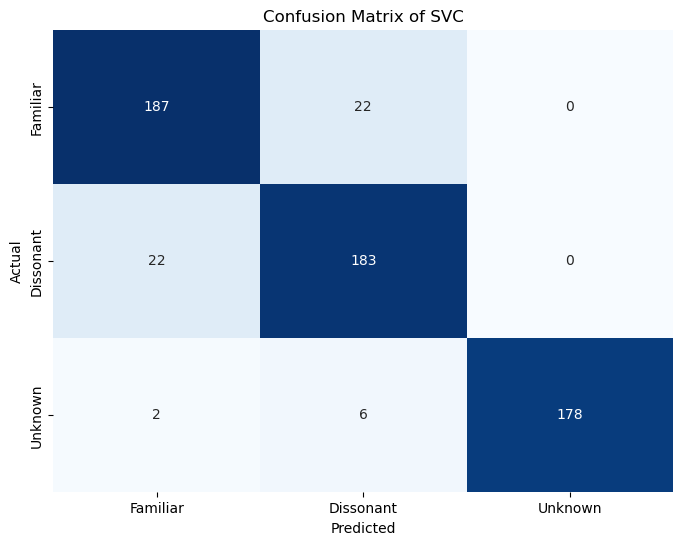

In [7]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Familiar','Dissonant','Unknown'], columns=['Familiar','Dissonant','Unknown'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix of SVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [8]:
# Load the pickle file (replace 'your_data_file.pkl' with the path to your pickle file)
pickle_file_path = '/home/MinnieMouse/project/epmem_edit/experiments/gpt2-small/experiment_1_1/historical_data_gen.pkl'
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)


print(len(data['a_normalization_data'][2][11]))

3072


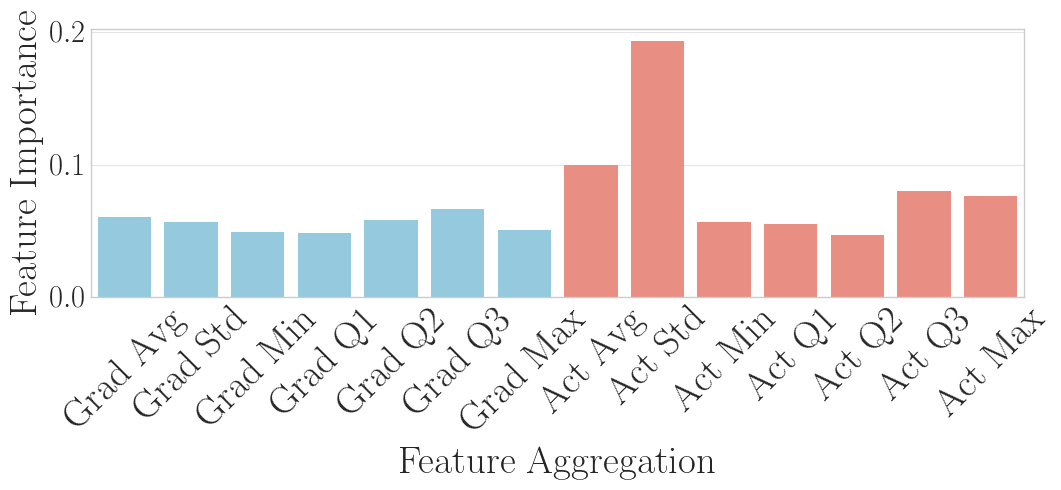

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the directories exist
os.makedirs('../analysis/figures', exist_ok=True)

# Assuming 'classifier' is your trained Random Forest model
rf_feature_importance = classifier.feature_importances_
rf_feature_importance_df = pd.DataFrame({'Feature': range(len(rf_feature_importance)), 'Importance': rf_feature_importance})

# Aggregate the results
aggregated_results = np.array([np.sum(rf_feature_importance[:48]), 
                              np.sum(rf_feature_importance[48:96]),
                              np.sum(rf_feature_importance[96:336:5]),
                              np.sum(rf_feature_importance[96+1:336:5]),
                              np.sum(rf_feature_importance[96+2:336:5]),
                              np.sum(rf_feature_importance[96+3:336:5]),
                              np.sum(rf_feature_importance[96+4:336:5]),
                              np.sum(rf_feature_importance[336:384]), 
                              np.sum(rf_feature_importance[384:480]),
                              np.sum(rf_feature_importance[480::5]),
                              np.sum(rf_feature_importance[480+1::5]),
                              np.sum(rf_feature_importance[480+2::5]),
                              np.sum(rf_feature_importance[480+3::5]),
                              np.sum(rf_feature_importance[480+4::5])])

# Create a DataFrame for the aggregated results with the desired labels
aggregated_df = pd.DataFrame({
    'Feature': ['Grad Avg', 'Grad Std', 'Grad Min', 'Grad Q1', 'Grad Q2', 'Grad Q3', 'Grad Max', 'Act Avg', 'Act Std', 'Act Min', 'Act Q1', 'Act Q2', 'Act Q3', 'Act Max'],
    'Importance': aggregated_results
})

# plt.style.use('seaborn-whitegrid')
# plt.rcParams.update({
#     'font.size': 22,
#     'axes.labelsize': 24,
#     'axes.titlesize': 24,
#     'xtick.labelsize': 24,
#     'ytick.labelsize': 22,
#     'legend.fontsize': 24,
#     'font.family': 'serif',
#     'text.usetex': True,
#     'figure.figsize': (10, 8)
# })
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 26,
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'xtick.labelsize': 28,
    'ytick.labelsize': 22,
    'legend.fontsize': 24,
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (10, 8)
})

# Plot the feature importance horizontally with more space between labels
plt.figure(figsize=(12, 6))

# Add a grid with transparency
plt.grid(True, alpha=0.5)

# Define colors for gradients and activations
colors = ['skyblue'] * 7 + ['salmon'] * 7

# Plot using seaborn barplot
sns.barplot(x='Feature', y='Importance', data=aggregated_df, palette=colors)

# Add labels and title
plt.xlabel('Feature Aggregation')
plt.ylabel('Feature Importance')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust the layout for better appearance in a paper
plt.tight_layout(pad=2)

# Save the plot
plt.savefig('../analysis/figures/experiment_1_pt_feature_importance_act_grad.pdf')

# Show the plot
plt.show()


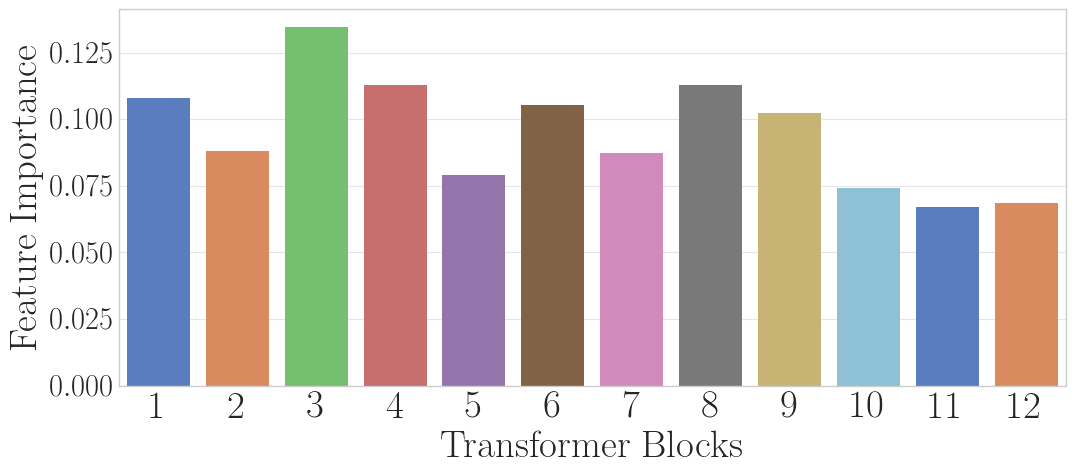

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the directories exist
os.makedirs('../analysis/figures', exist_ok=True)

# Assuming 'classifier' is your trained Random Forest model
rf_feature_importance = classifier.feature_importances_
rf_feature_importance_df = pd.DataFrame({'Feature': range(len(rf_feature_importance)), 'Importance': rf_feature_importance})

# Initialize an empty list to store the aggregated results
aggregated_results = []

# Loop from i = 0 to i = 11
for i in range(12):
    result = np.sum(rf_feature_importance[np.r_[i:4+i, 48+i:48+4+i, 96+i*20:96+(i+1)*20,
                                                336+i:336+4+i, 336+48+i:336+48+4+i, 432+i*20:432+(i+1)*20]])
    aggregated_results.append(result)

aggregated_results = np.array(aggregated_results)

# Create a DataFrame for the aggregated results with the desired labels
aggregated_df = pd.DataFrame({
    'Blocks': [f"{i}" for i in range(1, 13)],
    'Importance': aggregated_results
})

# plt.style.use('seaborn-whitegrid')
# plt.rcParams.update({
#     'font.size': 22,
#     'axes.labelsize': 24,
#     'axes.titlesize': 24,
#     'xtick.labelsize': 24,
#     'ytick.labelsize': 22,
#     'legend.fontsize': 24,
#     'font.family': 'serif',
#     'text.usetex': True,
#     'figure.figsize': (10, 8)
# })
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 26,
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'xtick.labelsize': 28,
    'ytick.labelsize': 22,
    'legend.fontsize': 24,
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (10, 8)
})

# Plot the feature importance horizontally with more space between labels
plt.figure(figsize=(12, 6))

# Add a grid with transparency
plt.grid(True, alpha=0.5)

# Plot using seaborn barplot
sns.barplot(x='Blocks', y='Importance', data=aggregated_df, palette='muted')

# Add labels and title
plt.xlabel('Transformer Blocks')
plt.ylabel('Feature Importance')

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Adjust the layout for better appearance in a paper
plt.tight_layout(pad=2)

# Save the plot
plt.savefig('../analysis/figures/experiment_1_pt_feature_importance_blocks.pdf')

# Show the plot
plt.show()
